NOTE: THIS NOTEBOOK DEPENDS ON 'aqi_augmented.csv' TO BE GENERATED FROM 'Create Master Data Source Regression.ipynb'

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sci
from sklearn.decomposition import PCA
import seaborn as sns
import math

In [2]:
aqi_df = pd.read_csv('datasets/aqi_augmented.csv', index_col = 0)
aqi_df.head()

C:\Users\Owner\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,STATE_NAME,COUNTY_CODE,DATE,AQI,FIRES_COUNT_COUNTY_0_WEEK_PRIOR,FIRES_SIZE_COUNTY_0_WEEK_PRIOR,FIRES_COUNT_STATE_0_WEEK_PRIOR,FIRES_SIZE_STATE_0_WEEK_PRIOR,FIRES_COUNT_COUNTY_1_WEEK_PRIOR,FIRES_SIZE_COUNTY_1_WEEK_PRIOR,...,AQI_5_DAY_OFFSET,AQI_6_DAY_OFFSET,AQI_7_DAY_OFFSET,AQI_-1_DAY_OFFSET,AQI_-7_DAY_OFFSET,AQI_-6_DAY_OFFSET,AQI_-5_DAY_OFFSET,AQI_-4_DAY_OFFSET,AQI_-3_DAY_OFFSET,AQI_-2_DAY_OFFSET
0,Alabama,15,1992-01-01,12,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,15,1992-01-07,28,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN
2,Alabama,15,1992-01-13,6,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,32.0,NaN,NaN,NaN,25.0,NaN,NaN,46.0,NaN
3,Alabama,15,1992-01-19,12,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,38.0,NaN,NaN,NaN,46.0,NaN,NaN,36.0,NaN
4,Alabama,15,1992-01-25,13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,55.0,NaN,NaN,NaN,36.0,NaN,NaN,26.0,NaN


In [3]:
# # fill in previous days with a back-fill (can't have blank features)
# last = -7
# for d in range(-1, last -1, -1):
#     col_name = f'AQI_{d}_DAY_OFFSET'
#     prev_name = f'AQI_{d+1}_DAY_OFFSET' if d != -1 else 'AQI'
#     aqi_df[col_name][pd.isnull(aqi_df[col_name])] = aqi_df[prev_name][pd.isnull(aqi_df[col_name])]

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [3]:
aqi_df.head()

,STATE_NAME,COUNTY_CODE,DATE,AQI,FIRES_COUNT_COUNTY_0_WEEK_PRIOR,FIRES_SIZE_COUNTY_0_WEEK_PRIOR,FIRES_COUNT_STATE_0_WEEK_PRIOR,FIRES_SIZE_STATE_0_WEEK_PRIOR,FIRES_COUNT_COUNTY_1_WEEK_PRIOR,FIRES_SIZE_COUNTY_1_WEEK_PRIOR,...,AQI_5_DAY_OFFSET,AQI_6_DAY_OFFSET,AQI_7_DAY_OFFSET,AQI_-1_DAY_OFFSET,AQI_-7_DAY_OFFSET,AQI_-6_DAY_OFFSET,AQI_-5_DAY_OFFSET,AQI_-4_DAY_OFFSET,AQI_-3_DAY_OFFSET,AQI_-2_DAY_OFFSET
0,Alabama,15,1992-01-01,12,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,15,1992-01-07,28,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN
2,Alabama,15,1992-01-13,6,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,32.0,NaN,NaN,NaN,25.0,NaN,NaN,46.0,NaN
3,Alabama,15,1992-01-19,12,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,38.0,NaN,NaN,NaN,46.0,NaN,NaN,36.0,NaN
4,Alabama,15,1992-01-25,13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,55.0,NaN,NaN,NaN,36.0,NaN,NaN,26.0,NaN


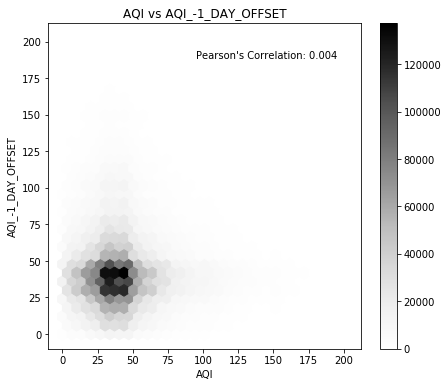

In [4]:
def trim_percent(arr1, arr2, percent):
    # cut trim percent off data end based on order provided for both features
    trim = int(percent*arr1.shape[0]/100.0)
    o1, o2 = arr1.argsort(), arr2.argsort()
    keep = list(set(o1) - (set(o1[-trim:]) | set(o2[-trim:])))
    return arr1[keep], arr2[keep]

def compare_2_features(df, feature1, feature2, save = False, verbose = True,\
                       hexbin=False, cmap = 'Greys', percent = .1, log = True, bins = 30):
    # get numpy versions
    arr1 = df[feature1].to_numpy()
    arr2 = df[feature2].to_numpy()
    
    # remove rows where one doesn't exist
    is_na = np.isnan(arr1) | np.isnan(arr2)
    arr1, arr2 = arr1[~is_na], arr2[~is_na]
    
    # remove outliers
    arr1, arr2 = trim_percent(arr1, arr2, percent)
    
    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(7,6)
    
    if hexbin:
        plt.hexbin(arr1, arr2, gridsize=bins, bins='log' if log else None, cmap=cmap)
    else:
        plt.hist2d(arr1, arr2, bins=mpl.colors.LogNorm() if log else None, cmap=cmap, norm=norm)
    cb = plt.colorbar()
    
    # add pearsons coefficient of correlation
    r,_ = sci.stats.pearsonr(arr1, arr2)
    ax.text(0.7, 0.9, f'Pearson\'s Correlation: {r:.3f}',
        verticalalignment='center', horizontalalignment='center',
        transform=ax.transAxes,
        fontsize=10)
    
    plt.title(f"{feature1} vs {feature2}")
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    if save:
        plt.savefig(save)
    if verbose:
        plt.show()
    plt.close()
compare_2_features(aqi_df, 'AQI', 'AQI_-1_DAY_OFFSET', 'analysis_plots/hist2D/log_aqi_dayprior.svg', hexbin = True, log = False, bins = 30)

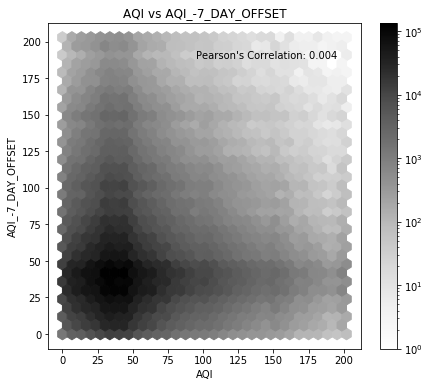

In [45]:
compare_2_features(aqi_df, 'AQI', 'AQI_-7_DAY_OFFSET', 'analysis_plots/hist2D/log_aqi_weekprior.svg', hexbin = True, log = True, bins = 30)

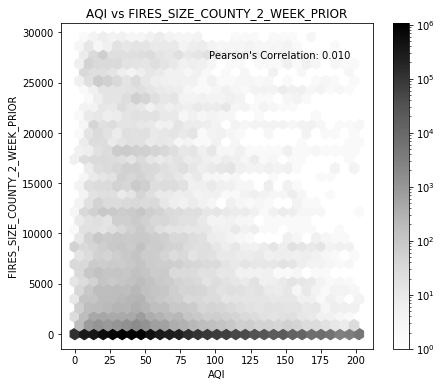

In [46]:
compare_2_features(aqi_df, 'AQI', 'FIRES_SIZE_COUNTY_2_WEEK_PRIOR', 'analysis_plots/hist2D/log_aqi_firesize_2weekprior.svg', hexbin = True, log = True, bins = 30)

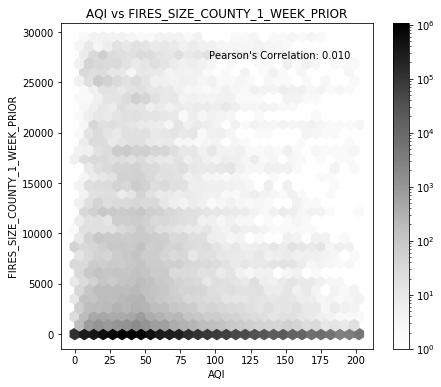

In [47]:
compare_2_features(aqi_df, 'AQI', 'FIRES_SIZE_COUNTY_1_WEEK_PRIOR', 'analysis_plots/hist2D/log_aqi_firesize_1weekprior.svg', hexbin = True, log = True, bins = 30)

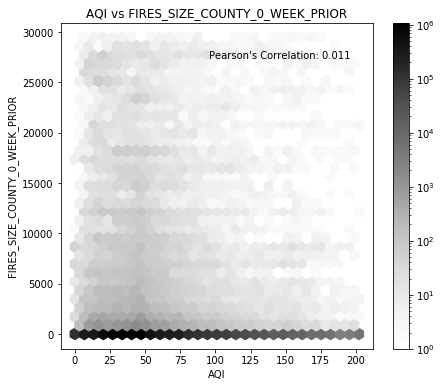

In [48]:
compare_2_features(aqi_df, 'AQI', 'FIRES_SIZE_COUNTY_0_WEEK_PRIOR', 'analysis_plots/hist2D/log_aqi_firesize_0weekprior.svg', hexbin = True, log = True, bins = 30)

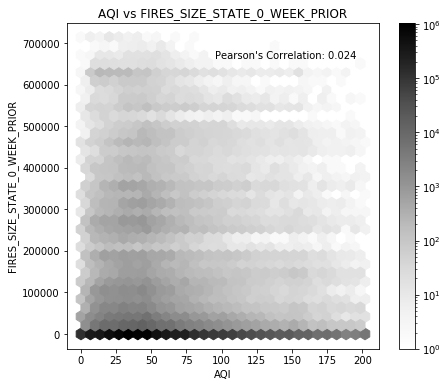

In [49]:
compare_2_features(aqi_df, 'AQI', 'FIRES_SIZE_STATE_0_WEEK_PRIOR', 'analysis_plots/hist2D/log_aqi_firesize_state_0weekprior.svg', hexbin = True, log = True, bins = 30)

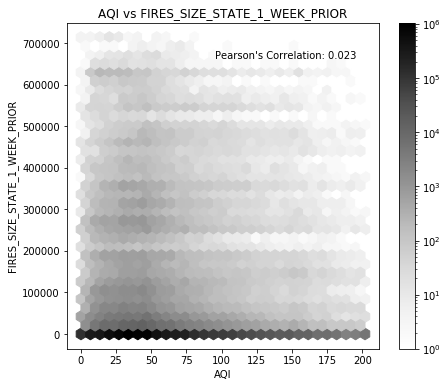

In [50]:
compare_2_features(aqi_df, 'AQI', 'FIRES_SIZE_STATE_1_WEEK_PRIOR', 'analysis_plots/hist2D/log_aqi_firesize_state_1weekprior.svg', hexbin = True, log = True, bins = 30)

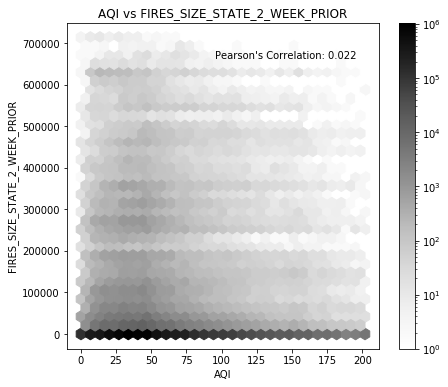

In [51]:
compare_2_features(aqi_df, 'AQI', 'FIRES_SIZE_STATE_2_WEEK_PRIOR', 'analysis_plots/hist2D/log_aqi_firesize_state_2weekprior.svg', hexbin = True, log = True, bins = 30)

In [8]:
# now we will do pca! not sure how this is going to go with the size of the data being what it is
features = list(set(aqi_df.columns) - ({'STATE_NAME', 'COUNTY_CODE', 'DATE'} | {f'AQI_{i}_DAY_OFFSET' for i in range(2,8)}))
filtered_df = aqi_df[features].dropna(axis=0, how='any')
aqi_vals = filtered_df['AQI_1_DAY_OFFSET'].to_numpy()
features = filtered_df.drop('AQI_1_DAY_OFFSET', axis = 1).to_numpy()
# remove outliers
order = aqi_vals.argsort()
trim = int(.1*filtered_df.shape[0]/100.0)
aqi_vals = aqi_vals[order[:-trim]]
features = features[order[:-trim],:]

In [9]:
# actually run pca after standardizing
sc = StandardScaler()
sc.fit(features)
features = sc.transform(features)
pca = PCA(n_components=2)
pca.fit(features)
pca_components = pca.transform(features)
pca_components.shape

(6440101, 2)

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


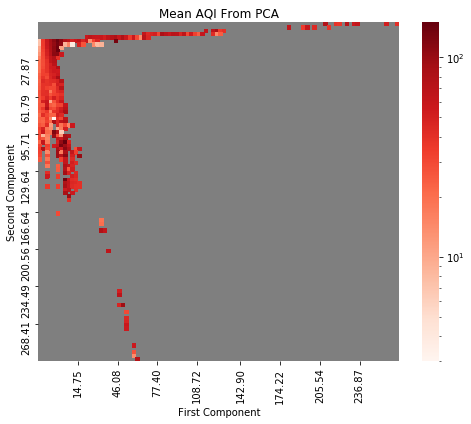

In [40]:
# plot the results as a binned heatmap
log = True
fig, ax = plt.subplots()
fig.set_size_inches(7,6)

# clearly can have nan where there were no points
denominator, xedges, yedges = np.histogram2d(pca_components[:,0],pca_components[:,1],bins=100)
numerator, _, _ = np.histogram2d(pca_components[:,0],pca_components[:,1],bins=[xedges, yedges], weights=aqi_vals)
aqi_mean_pca = numerator/denominator

# do initial plot
if log:
    cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(np.nanmin(aqi_mean_pca))), 1+math.ceil(math.log10(np.nanmax(aqi_mean_pca))))]
    g = sns.heatmap(aqi_mean_pca, cmap="Reds", mask=np.isnan(aqi_mean_pca),\
                    norm=mpl.colors.LogNorm(vmin=aqi_mean_pca.min(), vmax=aqi_mean_pca.max()),\
                    cbar_kws={"ticks": cbar_ticks})
else:
    g = sns.heatmap(aqi_mean_pca, cmap="Reds", mask=np.isnan(aqi_mean_pca))

# format labels and axis
num_ticks = 10
idx = np.round(np.linspace(0, xedges.shape[0]-1, num_ticks)).astype(int)[1:-1]

xedges_tick, yedges_tick = xedges[idx], yedges[idx]
g.set_xticks(idx)
g.set_xticklabels([f'{x:.2f}' for x in xedges_tick])
g.set_xlabel('First Component')
g.set_yticks(idx)
g.set_yticklabels([f'{y:.2f}' for y in yedges_tick])
g.set_ylabel('Second Component')
g.set_title('Mean AQI From PCA')
g.set_facecolor('tab:grey')
plt.tight_layout()
plt.savefig(f'analysis_plots/hist2D/pca_mean_aqi_log_{log}.svg')

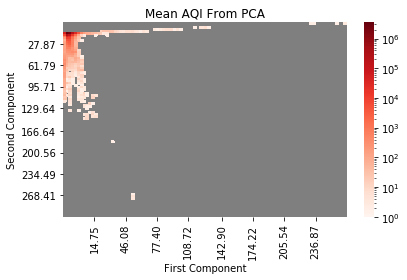

In [41]:
log = True
# plot true histogram of where samples were
counts, xedges, yedges = np.histogram2d(pca_components[:,0],pca_components[:,1],bins=100)

# do initial plot
if log:
    counts[counts == 0] = 1
    cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(np.nanmin(counts))), 1+math.ceil(math.log10(np.nanmax(counts))))]
    g = sns.heatmap(counts, cmap="Reds", mask = counts==1,\
                   norm=mpl.colors.LogNorm(vmin=aqi_mean_pca.min(), vmax=aqi_mean_pca.max()),\
                   cbar_kws={"ticks": cbar_ticks})
else:
    g = sns.heatmap(counts, cmap="Reds", mask = counts==0)

# format labels and axis
num_ticks = 10
idx = np.round(np.linspace(0, xedges.shape[0]-1, num_ticks)).astype(int)[1:-1]

xedges, yedges = xedges[idx], yedges[idx]
g.set_xticks(idx)
g.set_xticklabels([f'{x:.2f}' for x in xedges])
g.set_xlabel('First Component')
g.set_yticks(idx)
g.set_yticklabels([f'{y:.2f}' for y in yedges])
g.set_ylabel('Second Component')
g.set_title('Mean AQI From PCA')
g.set_facecolor('tab:grey')
plt.tight_layout()
plt.savefig(f'analysis_plots/hist2D/pca_count_log_{log}.svg')